In [1]:
# sentiment analysis with bert tutorial:
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
%matplotlib inline

In [6]:
%config InlineBackend.figure_format='retina'

In [7]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Load & Explore

In [8]:
fp = '../data/train.csv'
df = pd.read_csv(fp)
df.head()

,Unnamed: 0,text,label
0,36335,ATHENS (Reuters) - Turkish President Tayyip Er...,1
1,12384,"Ted Cruz would be fair, honest and most of all...",0
2,24419,WASHINGTON (Reuters) - White House Chief of St...,1
3,24740,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,1
4,27039,"SIGONELLA, Italy (Reuters) - U.S. President Do...",1


In [9]:
df.shape

(35918, 3)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 3 columns):
Unnamed: 0    35918 non-null int64
text          35918 non-null object
label         35918 non-null int64
dtypes: int64(2), object(1)
memory usage: 842.0+ KB


In [47]:
df.loc[:,'text_length'] = df.text.str.len()
df.head()

,Unnamed: 0,text,label,text_length
0,36335,ATHENS (Reuters) - Turkish President Tayyip Er...,1,409
1,12384,"Ted Cruz would be fair, honest and most of all...",0,1498
2,24419,WASHINGTON (Reuters) - White House Chief of St...,1,3077
3,24740,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,1,400
4,27039,"SIGONELLA, Italy (Reuters) - U.S. President Do...",1,755


In [50]:
df.text_length.describe()

count    35918.000000
mean      2469.403196
std       2161.763423
min          1.000000
25%       1234.000000
50%       2182.000000
75%       3097.000000
max      51794.000000
Name: text_length, dtype: float64

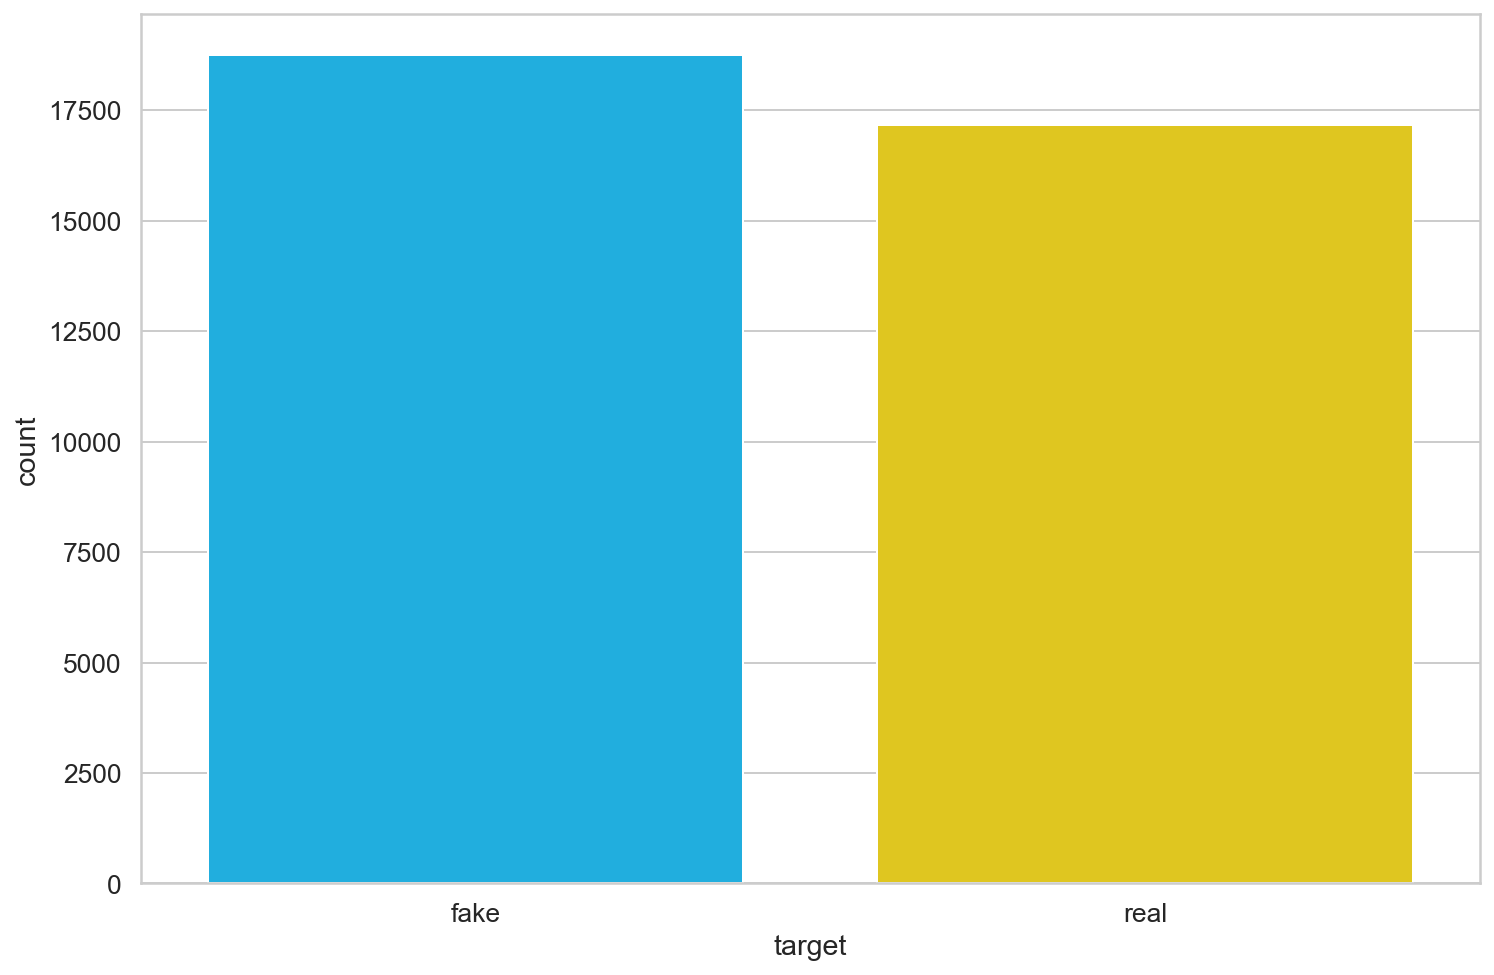

In [15]:
ax = sns.countplot(df.label)
plt.xlabel('target')
ax.set_xticklabels(['fake', 'real'])
plt.show()

# Data Preparation

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [20]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [21]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [28]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
#     padding='longest',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [29]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [30]:
# attention mask has the same length as the encoding
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [33]:
# can inverse tokenization to look at special tokens
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [40]:
token_lens = []
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512) # may want to increase given longer article length (mean=2500)
    token_lens.append(len(tokens))

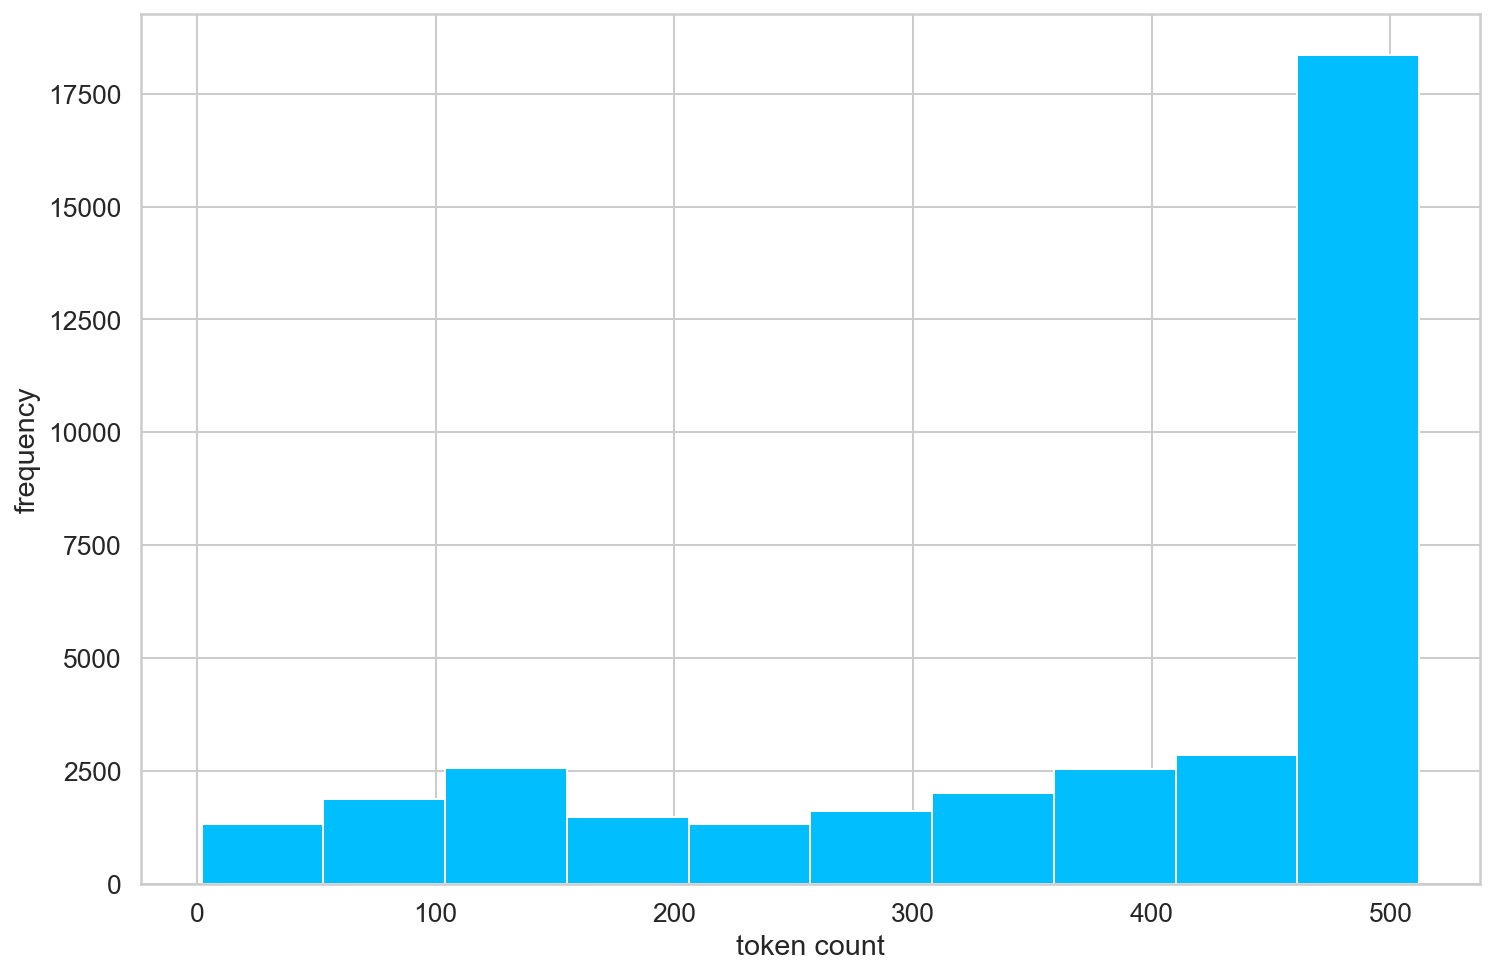

In [45]:
# look at distribution of sequence lengths
# most articles are longer than 512 words, have probably been clipped
plt.hist(token_lens)
plt.xlabel('token count')
plt.ylabel('frequency')
plt.show()

In [51]:
# set max sequence length
MAX_LEN = 500

# Create Custom PyTorch Dataset

In [52]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        txt = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'article_text': txt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [74]:
df.head()

,Unnamed: 0,text,label,text_length
0,36335,ATHENS (Reuters) - Turkish President Tayyip Er...,1,409
1,12384,"Ted Cruz would be fair, honest and most of all...",0,1498
2,24419,WASHINGTON (Reuters) - White House Chief of St...,1,3077
3,24740,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,1,400
4,27039,"SIGONELLA, Italy (Reuters) - U.S. President Do...",1,755


In [75]:
df_train, df_test = train_test_split(
    df[['text', 'label']],
    test_size=0.2,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((28734, 2), (3592, 2), (3592, 2))

In [109]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FakeNewsDataset(
        texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [110]:
train_data_loader.batch_size

16

In [111]:
# data = next(iter(train_data_loader))
data = train_data_loader.dataset[0]
data.keys()

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['article_text', 'input_ids', 'attention_mask', 'labels'])

In [112]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([500])
torch.Size([500])
torch.Size([])


# BERT Model

In [91]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [113]:
type(bert_model)

transformers.models.bert.modeling_bert.BertModel

In [92]:
# last_hidden_state = hidden state from last layer of pretrained model
# pooled_output = like summary of content
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [94]:
last_hidden_state

'last_hidden_state'

In [99]:
# last_hidden_state.shape # = hidden size from pretrained model

In [102]:
# pooled_output.shape

In [100]:
bert_model.config.hidden_size

768

In [114]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
        def forward(self, input_ids, attention_mask):
            _, pooled_output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            output = self.drop(pooled_output)
            output = self.out(output)
            return self.softmax(output)

In [116]:
model = SentimentClassifier(2)
model = model.to(device) # move to GPU if available

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [117]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([500])
torch.Size([500])


In [118]:
# F.softmax(model(input_ids, attention_mask), dim=1)
model(input_ids, attention_mask)

NotImplementedError: 